### Import necessary libraries
In this first cell, we import the necessary Python libraries for spatial data manipulation, querying OpenStreetMap (OSM) data, and plotting.

In [120]:
# Import necessary libraries
import overpy
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, LineString, Point
from shapely.ops import unary_union, linemerge
from shapely.validation import make_valid
from shapely.errors import TopologicalError
import matplotlib.pyplot as plt
import networkx as nx
import contextily as cx
import plotly.graph_objects as go
import math
%matplotlib widget

### Helper functions
We define some key helper functions used in processing building geometries and calculating the midpoints of building facades.

In [121]:
# Helper function to close small gaps between lines
def close_small_gaps(line, tolerance=0.0001):
    if line.is_ring:  # Already closed
        return line
    # Check if the start and end points are within the tolerance
    if line.coords[0] != line.coords[-1]:
        start = line.coords[0]
        end = line.coords[-1]
        if LineString([start, end]).length <= tolerance:
            coords = list(line.coords)
            coords[-1] = start
            return LineString(coords)
    return line

# Function to get facade midpoints for each building's polygon
def get_facade_midpoints_per_building(geometry, building_id):
    midpoints = []
    
    # Handle MultiPolygon by iterating over each Polygon
    if geometry.geom_type == 'MultiPolygon':
        for polygon in geometry.geoms:
            exterior_coords = list(polygon.exterior.coords)
            
            # Process each edge of the polygon and compute its midpoint
            for i in range(len(exterior_coords) - 1):
                p1 = exterior_coords[i]
                p2 = exterior_coords[i + 1]
                
                # Create midpoint
                midpoint = Point((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
                
                # Store facade midpoint data
                midpoints.append({
                    'building_id': building_id, 
                    'geometry': midpoint, 
                    'facade_index': i
                })
    # Handle single Polygon
    elif geometry.geom_type == 'Polygon':
        exterior_coords = list(geometry.exterior.coords)
        
        # Process each edge of the polygon and compute its midpoint
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            
            # Create midpoint
            midpoint = Point((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
            
            # Store facade midpoint data
            midpoints.append({
                'building_id': building_id, 
                'geometry': midpoint, 
                'facade_index': i
            })
    
    return midpoints


# Function to process OSM building elements and extract geometries
def process_building(element):
    outer_ways, inner_ways = [], []  # Initialize as two empty lists
    
    # Process relations
    if isinstance(element, overpy.Relation):
        for member in element.members:
            if isinstance(member, (overpy.Way, overpy.RelationWay)): 
                if member.role == 'outer':
                    outer_ways.append(member)
                elif member.role == 'inner':
                    inner_ways.append(member)

        if not outer_ways:
            return None  # Skip if no outer ways

        outer_polygons, outer_lines = [], []
        for outer_way in outer_ways:
            if isinstance(outer_way, overpy.RelationWay):
                outer_way = outer_way.resolve()

            nodes = [(float(node.lon), float(node.lat)) for node in outer_way.nodes]
            if len(nodes) >= 2:
                line = LineString(nodes)
                outer_lines.append(line)

        try:
            merged_line = linemerge(outer_lines)
            if isinstance(merged_line, LineString):
                merged_line = close_small_gaps(merged_line)
                if merged_line.is_ring:
                    outer_polygon = Polygon(merged_line)
                    if outer_polygon.is_valid:
                        outer_polygons.append(outer_polygon)
                    else:
                        outer_polygon = make_valid(outer_polygon)
                        if outer_polygon.is_valid:
                            outer_polygons.append(outer_polygon)
            elif isinstance(merged_line, MultiPolygon):
                outer_polygons = list(merged_line.geoms)
            else:
                outer_polygons = [Polygon(line) for line in outer_lines if line.is_ring and Polygon(line).is_valid]
        except TopologicalError as e:
            outer_polygons = [Polygon(line) for line in outer_lines if line.is_ring and Polygon(line).is_valid]

        if not outer_polygons:
            return None

        if len(outer_polygons) > 1:
            geometry = max(outer_polygons, key=lambda p: p.area)
        else:
            geometry = outer_polygons[0]

        # Add holes (inner polygons)
        inner_polygons = []
        for inner_way in inner_ways:
            if isinstance(inner_way, overpy.RelationWay):
                inner_way = inner_way.resolve()

            nodes = [(float(node.lon), float(node.lat)) for node in inner_way.nodes]
            if len(nodes) >= 4:
                if nodes[0] != nodes[-1]:
                    nodes.append(nodes[0])
                inner_polygon = Polygon(nodes)
                if inner_polygon.is_valid:
                    inner_polygons.append(inner_polygon)

        try:
            geometry = Polygon(geometry.exterior.coords, holes=[inner.exterior.coords for inner in inner_polygons if geometry.contains(inner)])
        except TopologicalError as e:
            return None

        if not geometry.is_valid:
            geometry = geometry.buffer(0)
            if not geometry.is_valid:
                return None

    # Simple polygons (for ways)
    else:
        nodes = [(float(node.lon), float(node.lat)) for node in element.nodes]
        if len(nodes) >= 4:
            if nodes[0] != nodes[-1]:
                nodes.append(nodes[0])
            try:
                geometry = Polygon(nodes)
                if not geometry.is_valid:
                    geometry = geometry.buffer(0)
                    if not geometry.is_valid:
                        return None
            except TopologicalError as e:
                return None
        else:
            return None

    height = element.tags.get('height')
    levels = element.tags.get('building:levels')
    building_type = element.tags.get('building')
    name = element.tags.get('name')

    if height:
        try:
            height = float(height)
        except ValueError:
            height = None

    return {
        'osm_id': element.id,
        'geometry': geometry,
        'height': height,
        'levels': levels,
        'building_type': building_type,
        'name': name
    }

close_small_gaps: This function ensures that small gaps between lines are closed. It checks whether the start and end of a line are within a given tolerance and closes the gap if necessary.

process_building: Process of all buildings by properly handlying polygons and multypoligons, as well as situations in which in one relation more than one detached building is present.

get_facade_midpoints_per_building: Given a building polygon, this function calculates and returns the midpoints of each facade (edge) of the building.

### Querying OSM Data
We use Overpass API to query OpenStreetMap for building data within a bounding box of interest.

In [122]:
# Query OSM and process building data using bounding box
lat_min, lon_min, lat_max, lon_max = 44.805803,10.328752,44.807306,10.332336

api = overpy.Overpass()

# Modify query to use bounding box (bbox)
query = f"""
[out:json][timeout:180];
(
  way["building"]({lat_min},{lon_min},{lat_max},{lon_max});
  relation["building"]({lat_min},{lon_min},{lat_max},{lon_max});
);
out body;
>;
out skel qt;
"""
result = api.query(query)

buildings = []
for element in result.ways + result.relations:
    if 'building' in element.tags:
        building_data = process_building(element)
        if building_data:
            buildings.append(building_data)


We query building data from OSM using the Overpass API for a specific geographical area defined by latitude and longitude coordinates.

The result includes ways and relations representing buildings.

### Processing Building Data
Now that we have building data, we process the results into a GeoDataFrame and prepare the data for further spatial analysis.

In [123]:
# Create a GeoDataFrame for building footprints
gdf = gpd.GeoDataFrame(buildings, crs="EPSG:4326")

# Filter for valid geometries
gdf = gdf[gdf.geometry.is_valid]

# Reproject to target CRS (EPSG:7791 - RDN2008 / UTM zone 32N)
target_crs = "EPSG:7791"
gdf_projected = gdf.to_crs(target_crs)

# Filter out small buildings (e.g., less than 10 square meters)
min_area = 10  # in square meters
gdf_projected = gdf_projected[gdf_projected.geometry.area > min_area]

In [124]:
gdf_projected

osm_id                                           geometry height  \
0    182136568  POLYGON ((605329.256 4962223.562, 605344.631 4...   None   
1    182136570  POLYGON ((605272.36 4962301.154, 605277.674 49...   None   
2    182136574  POLYGON ((605260.612 4962306.529, 605264.423 4...   None   
3    182136591  POLYGON ((605149.545 4962296.411, 605158.416 4...   None   
4    182136595  POLYGON ((605135.491 4962382.839, 605137.991 4...   None   
..         ...                                                ...    ...   
181    2427080  POLYGON ((605123.12 4962364.469, 605127.555 49...   None   
182    2427082  POLYGON ((605298.885 4962237.254, 605302.882 4...   None   
183    2427083  POLYGON ((605224.053 4962322.842, 605228.427 4...   None   
184    2427090  POLYGON ((605228.602 4962261.47, 605238.601 49...   None   
185    2427096  POLYGON ((605176.416 4962284.35, 605187.421 49...   None   

    levels building_type                     name  
0     None           yes                     None  
1     None           yes                     None  
2     None           yes                     None  
3     None           yes                     None  
4     None           yes                     None  
..     ...           ...                      ...  
181   None           yes                     None  
182   None           yes  Casa Cordero già Piazza  
183   None           yes                     None  
184   None           yes                     None  
185   None           yes                     None  

[183 rows x 6 columns]

<Axes: >

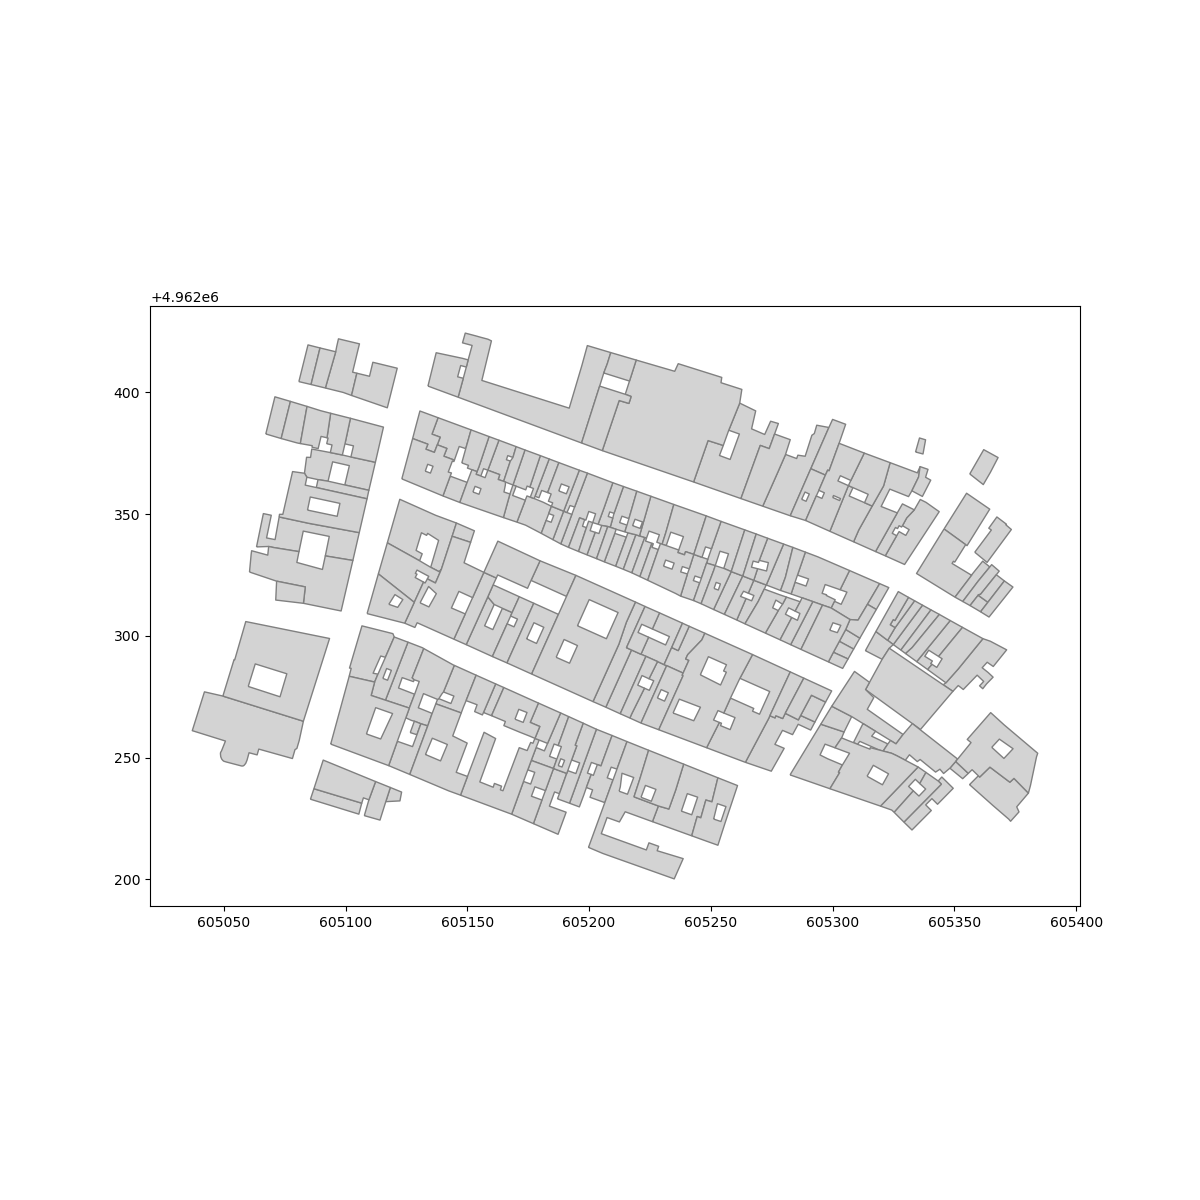

In [126]:
# Plot to verify midpoints per building
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all building footprints in grey
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

We store the building data in a GeoDataFrame.

We reproject the data into the EPSG:7791 coordinate system.

We filter out small buildings with an area of less than 10 square meters.

### Remove buildings that could cause problems
Identify builings and create polygons, remove all buildings intersecting polygons

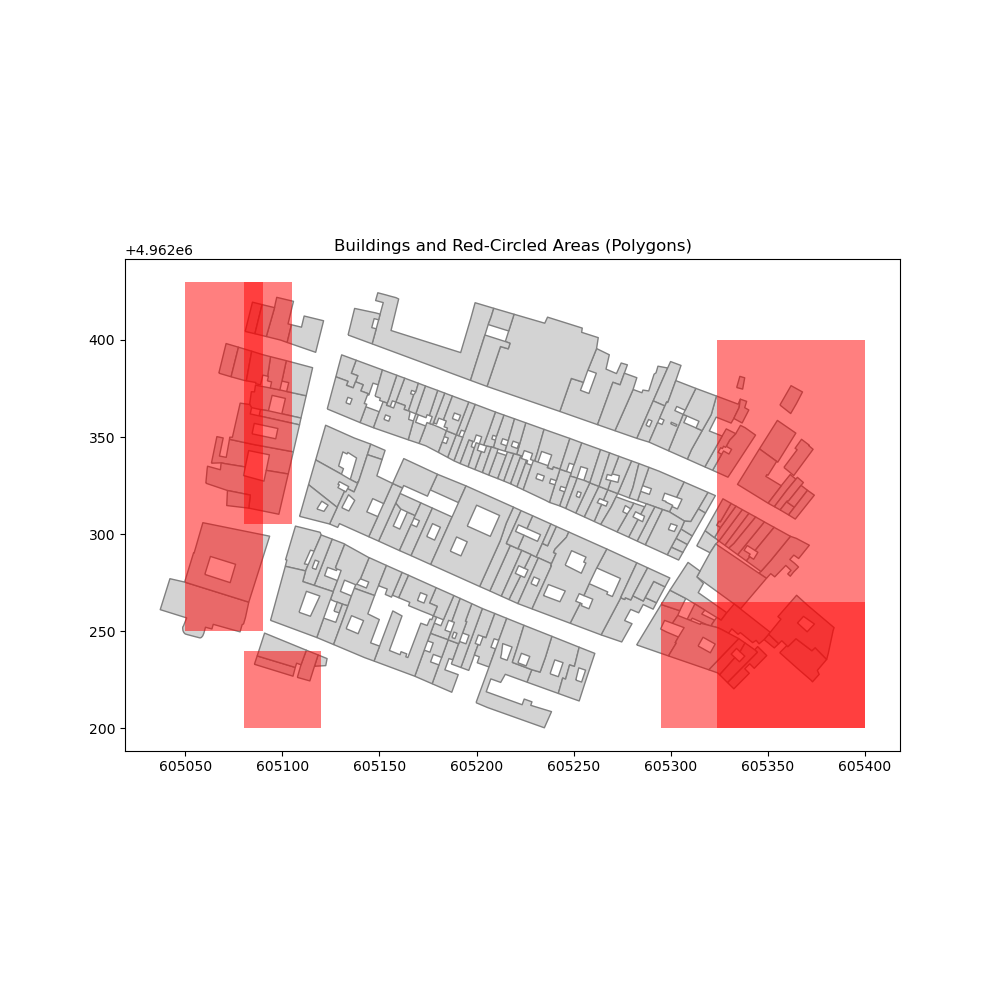

In [127]:
# Example polygons for red-circled areas (replace these with actual coordinates)
polygon_1 = Polygon([(605050, 4962250), (605050, 4962430), (605090, 4962430), (605090, 4962250)])
polygon_2 = Polygon([(605324, 4962200), (605324, 4962400), (605400, 4962400), (605400, 4962200)])
polygon_3 = Polygon([(605080, 4962305), (605080, 4962430), (605105, 4962430), (605105, 4962305)])
polygon_4 = Polygon([(605295, 4962200), (605295, 4962265), (605400, 4962265), (605400, 4962200)])
polygon_5 = Polygon([(605080, 4962200), (605080, 4962240), (605120, 4962240), (605120, 4962200)])

# Create a GeoDataFrame with multiple polygons
gdf_red_circles = gpd.GeoDataFrame(geometry=[polygon_1, polygon_2, polygon_3, polygon_4, polygon_5], crs=gdf_projected.crs)

# Visualize the polygons and the buildings
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original building GeoDataFrame
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot the red-circled areas as polygons
gdf_red_circles.plot(ax=ax, color='red', alpha=0.5)

plt.title("Buildings and Red-Circled Areas (Polygons)")
plt.show()

C:\Users\FedericoBattini\AppData\Local\Temp\ipykernel_8608\3904555827.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_filtered = gdf_projected[~gdf_projected.intersects(gdf_red_circles.unary_union)]


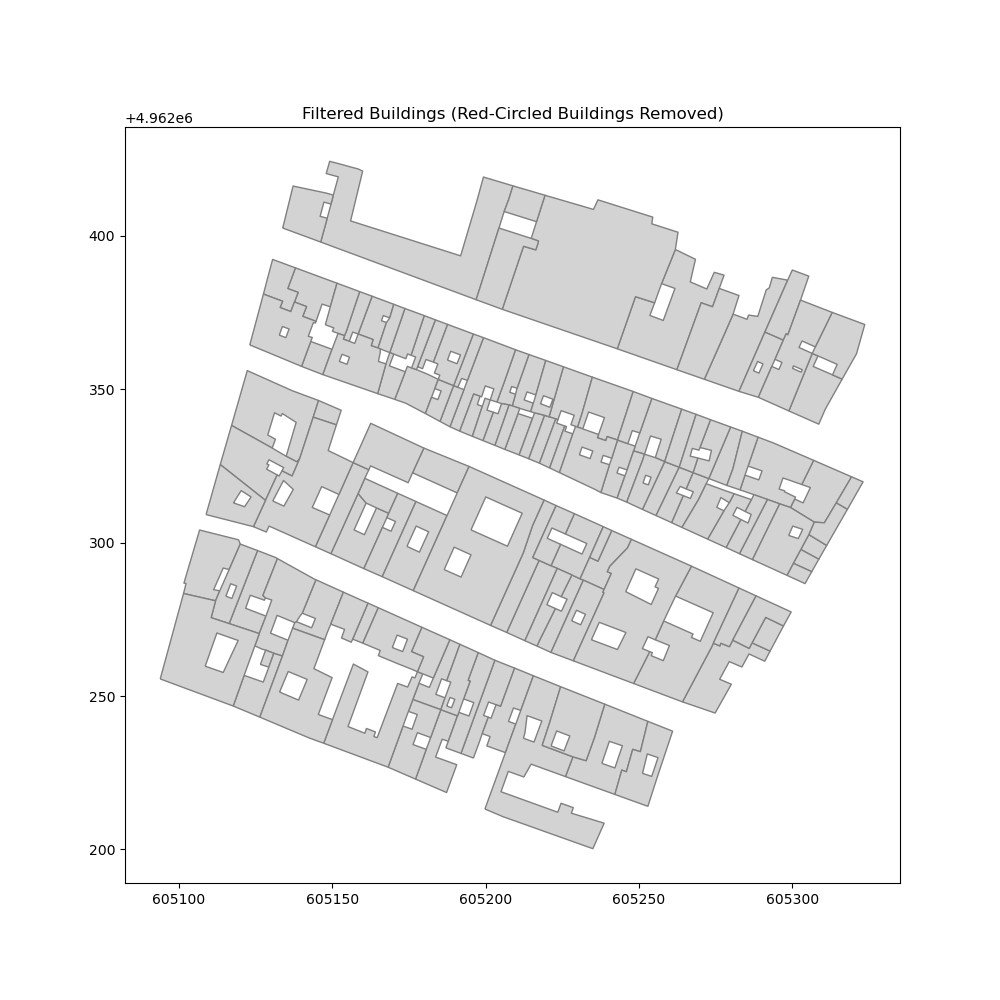

In [128]:
# Perform spatial filtering to remove buildings that intersect with the red-circled areas
gdf_filtered = gdf_projected[~gdf_projected.intersects(gdf_red_circles.unary_union)]

# Visualize the filtered buildings
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the filtered buildings (those that are NOT in the red circles)
gdf_filtered.plot(ax=ax, color='lightgrey', edgecolor='grey')

plt.title("Filtered Buildings (Red-Circled Buildings Removed)")
plt.show()

In [129]:
gdf_projected = gdf_filtered.copy()

### Calculating Facade Midpoints
We calculate the midpoints of the facades for each building.

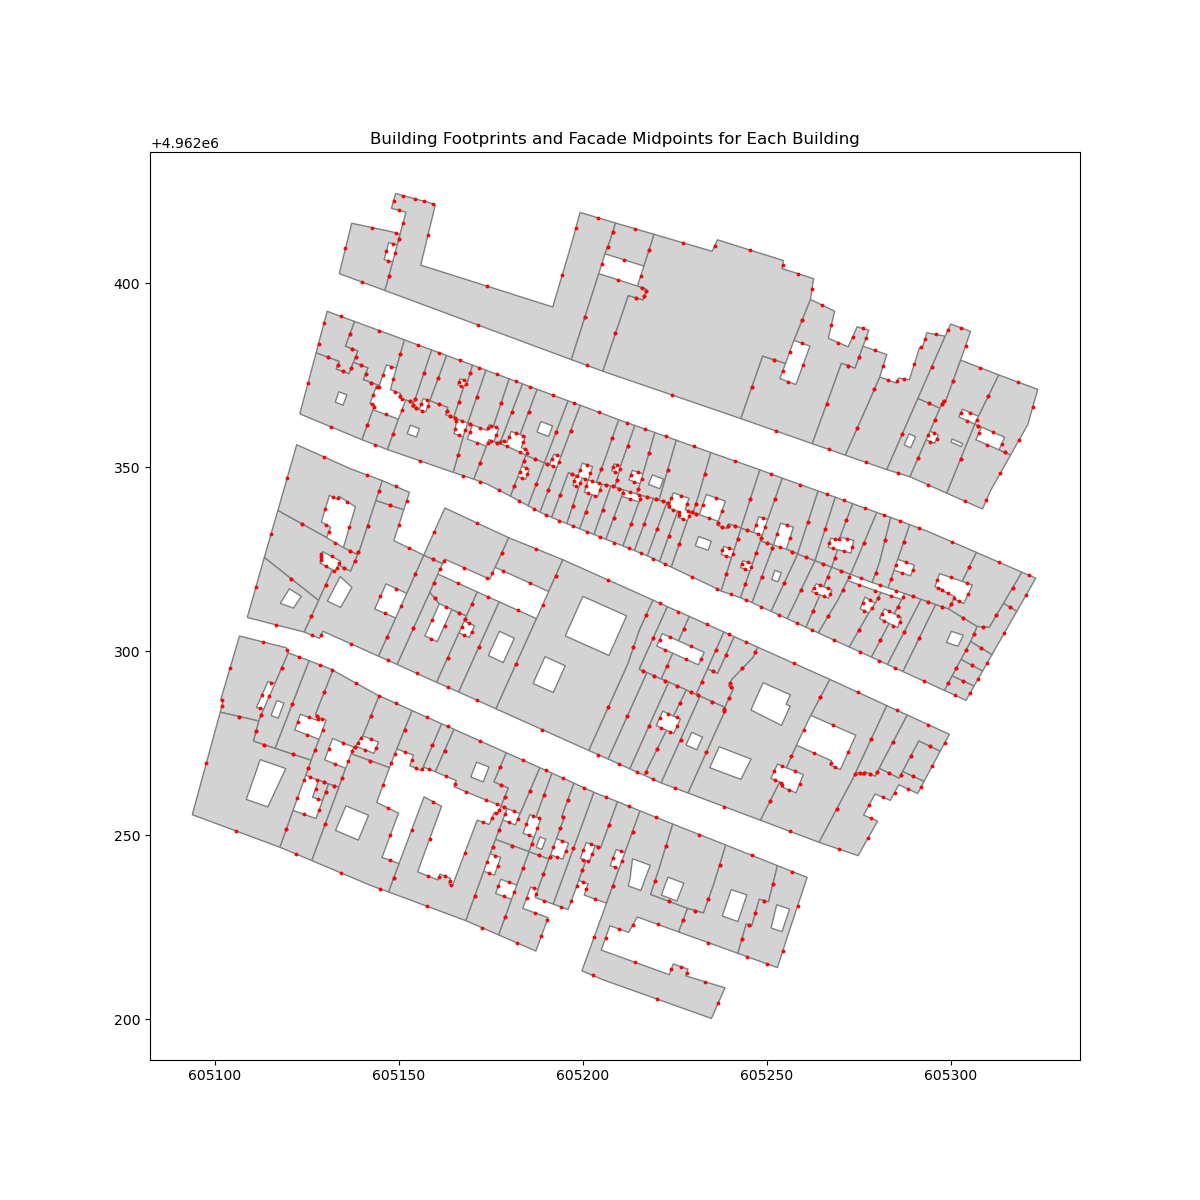

In [130]:
# Process each building footprint separately
facade_midpoints_data = []
for index, row in gdf_projected.iterrows():  # Iterate through rows with index
    building_id = row['osm_id'] if 'osm_id' in gdf_projected.columns else index  # Use OSM ID if available, otherwise use row index
    geometry = row['geometry']
    midpoints = get_facade_midpoints_per_building(geometry, building_id)
    facade_midpoints_data.extend(midpoints)

# Create a GeoDataFrame for facade midpoints
facade_midpoints_gdf = gpd.GeoDataFrame(facade_midpoints_data, crs=gdf_projected.crs)

# Plot to verify midpoints per building
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all building footprints in grey
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot facade midpoints in red
facade_midpoints_gdf.plot(ax=ax, color='red', markersize=3)

plt.title("Building Footprints and Facade Midpoints for Each Building")
plt.show()

This section computes the midpoints of each building facade and stores the results in a new GeoDataFrame.

### Analyzing Grouped Buildings
Here we perform spatial analysis to identify groups of adjacent buildings and find exterior boundaries of these groups.

In [131]:
# Parameters
buffer_distance = 0.1  # For joining buildings
min_segment_length = 1.0  # Minimum length for facade segments

# Use spatial join to find touching buildings
gdf_projected['temp_id'] = gdf_projected.index
gdf_buffered = gdf_projected.copy()
gdf_buffered['geometry'] = gdf_projected.geometry.buffer(buffer_distance)
joined_gdf = gpd.sjoin(gdf_buffered, gdf_buffered, how='inner', predicate='intersects')

# Create the graph from the spatial join results
G = nx.Graph()
for _, row in joined_gdf.iterrows():
    G.add_edge(row['temp_id_left'], row['temp_id_right'])

# Find connected components (groups of adjacent buildings)
connected_components = list(nx.connected_components(G))

# Assign group IDs to buildings based on connected components
gdf_projected['group_id'] = None
for group_id, component in enumerate(connected_components):
    if len(component) == 1:
        gdf_projected.loc[list(component), 'group_id'] = f'standalone_{group_id}'
    else:
        gdf_projected.loc[list(component), 'group_id'] = f'block_{group_id}'

We buffer the buildings slightly to join adjacent buildings and use spatial joins to group them into blocks or groups.

A graph is constructed to represent building adjacency, and connected components (groups) are identified.

### Processing and Plotting Exterior Boundaries and Midpoints
Finally, we plot the exterior boundaries and midpoints of building facades.

In [132]:
# Process each group and identify facade segments along the outer edge, including building IDs
facade_segments = []
exterior_boundaries = []

for group_id, group_gdf in gdf_projected.groupby('group_id'):
    merged_polygon = unary_union(group_gdf['geometry'])
    polygons = list(merged_polygon.geoms) if merged_polygon.geom_type == 'MultiPolygon' else [merged_polygon]

    for polygon in polygons:
        exterior_boundary = polygon.exterior
        exterior_boundaries.append({'group_id': group_id, 'geometry': exterior_boundary})
        
        for i in range(len(exterior_boundary.coords) - 1):
            p1 = exterior_boundary.coords[i]
            p2 = exterior_boundary.coords[i + 1]
            segment = LineString([p1, p2])
            
            if segment.length >= min_segment_length:
                for building_id, building in group_gdf.iterrows():
                    if building['geometry'].intersects(segment):
                        midpoint = segment.centroid
                        facade_segments.append({'group_id': group_id, 'building_id': building_id, 'geometry': midpoint})
                        break

# Create GeoDataFrames for facade segments and exterior boundaries
facade_segments_gdf = gpd.GeoDataFrame(facade_segments, crs=gdf_projected.crs)
exterior_boundaries_gdf = gpd.GeoDataFrame(exterior_boundaries, crs=gdf_projected.crs)

For each group of buildings, we compute the exterior boundary and the midpoints of building facades that are part of this boundary.

In [133]:
# Save your data as shapefiles and GeoJSONs
data_path = 'data/Street_view/'

# Save as GeoJSON
gdf_projected.to_file(data_path + "Bologna_buildings.geojson", driver="GeoJSON")
exterior_boundaries_gdf.to_file(data_path + "Bologna_exterior_boundaries.geojson", driver="GeoJSON")
facade_segments_gdf.to_file(data_path + "Bologna_facade_segments.geojson", driver="GeoJSON")


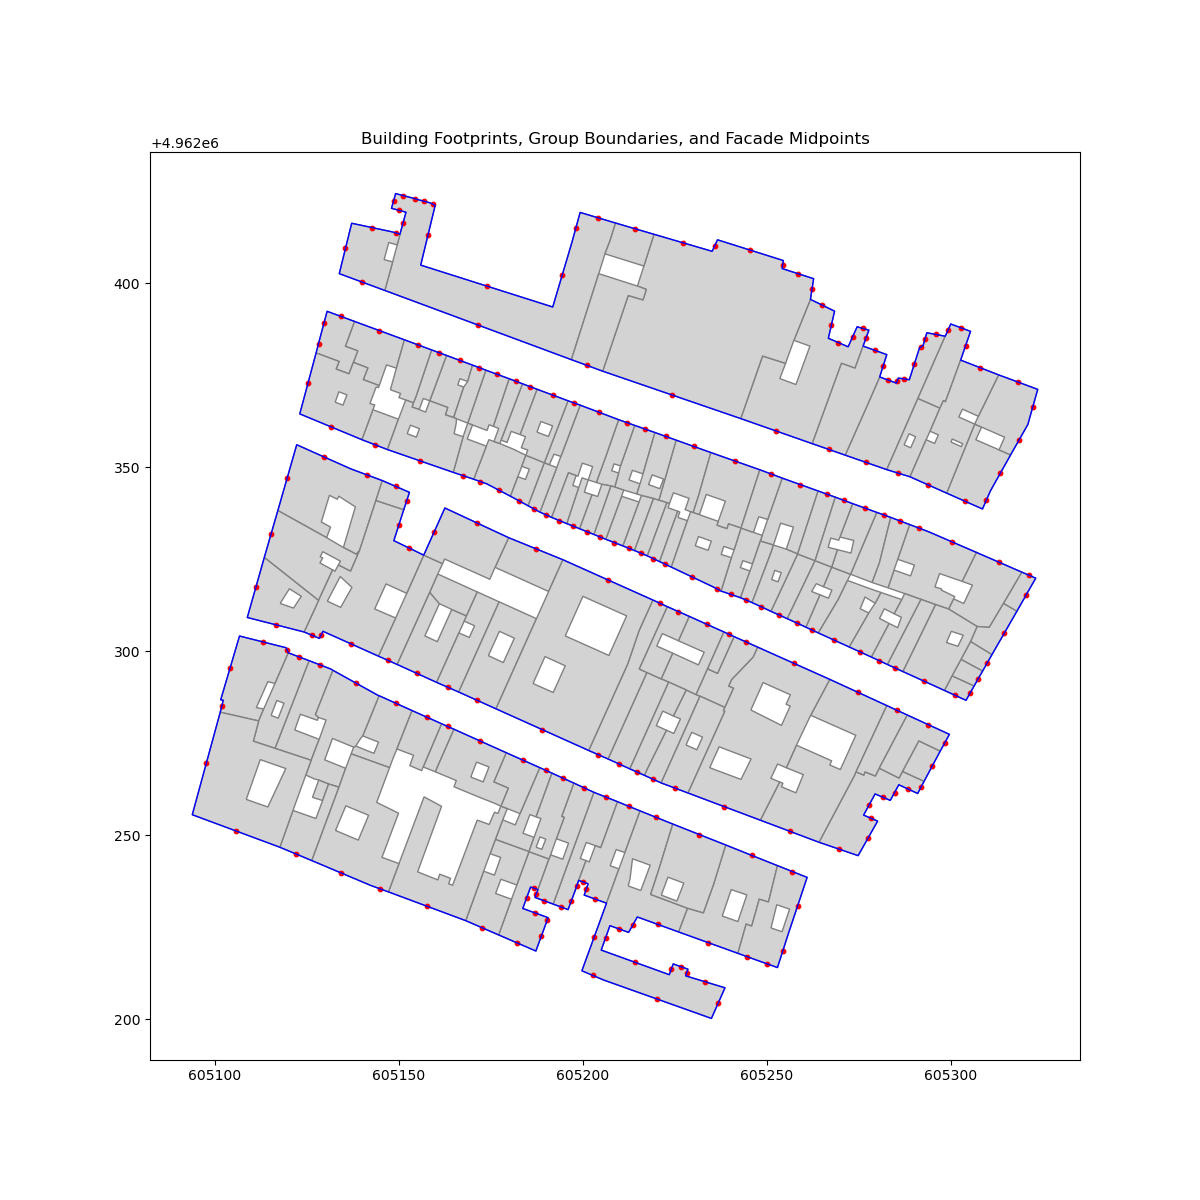

In [134]:
# Plot all buildings, boundaries, and midpoints on one map
fig, ax = plt.subplots(figsize=(12, 12))
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')
exterior_boundaries_gdf.plot(ax=ax, color='blue', linewidth=1)
facade_segments_gdf.plot(ax=ax, color='red', markersize=10)

#cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=15)
plt.title("Building Footprints, Group Boundaries, and Facade Midpoints")
plt.show()

The final plot shows the buildings, their boundaries, and the calculated facade midpoints.

In [135]:
# Helper function to calculate azimuth between two points
def calculate_azimuth(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    # Calculate azimuth as before
    azimuth = math.degrees(math.atan2(lon2 - lon1, lat2 - lat1))
    azimuth = (azimuth + 360) % 360  # Normalize azimuth to [0, 360]

    # Adjust for 90-degree counterclockwise shift
    adjusted_azimuth = (azimuth - 90) % 360

    return adjusted_azimuth


# Function to classify azimuth into cardinal direction with ±45° tolerance
def classify_orientation(azimuth):
    directions = {
        'N': 0,
        'NE': 45,
        'E': 90,
        'SE': 135,
        'S': 180,
        'SW': 225,
        'W': 270,
        'NW': 315
    }
    
    for direction, angle in directions.items():
        if abs(azimuth - angle) <= 45:
            return direction
    return 'N'

# Function to classify azimuth into only N, S, E, W directions with ±45° tolerance
def classify_orientation(azimuth):
    directions = {
        'N': 0,
        'E': 90,
        'S': 180,
        'W': 270
    }
    
    for direction, angle in directions.items():
        if abs(azimuth - angle) <= 45:  # ±45° tolerance for each direction
            return direction
    return 'N'

# Process facade midpoints to assign orientation based on exterior boundaries
def add_orientation_using_exterior_boundaries(facade_segments_gdf, exterior_boundaries_gdf):
    oriented_midpoints = []

    for index, row in facade_segments_gdf.iterrows():
        midpoint = row['geometry']
        group_id = row['group_id']

        # Get the corresponding exterior boundary for this group
        boundary_row = exterior_boundaries_gdf[exterior_boundaries_gdf['group_id'] == group_id]
        if boundary_row.empty:
            continue  # Skip if no matching boundary is found

        boundary = boundary_row.iloc[0]['geometry']  # Get the exterior boundary LINEARRING

        # Iterate over each segment of the exterior boundary
        exterior_coords = list(boundary.coords)
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            segment = LineString([p1, p2])

            # Check if the midpoint is near the segment (within a small buffer)
            if segment.distance(midpoint) < 1e-6:  # Adjust tolerance as needed
                azimuth = calculate_azimuth(p1, p2)
                orientation = classify_orientation(azimuth)

                # Add the orientation to the midpoint data
                oriented_midpoints.append({
                    'group_id': group_id,
                    'building_id': row['building_id'],
                    'geometry': midpoint,
                    'orientation': orientation
                })
                break  # Once we find the matching segment, we can stop
            
    # Create a new GeoDataFrame with oriented facade midpoints
    oriented_midpoints_gdf = gpd.GeoDataFrame(oriented_midpoints, geometry='geometry', crs=facade_segments_gdf.crs)
    
    return oriented_midpoints_gdf

# Apply the function to classify and add orientation to midpoints based on exterior boundaries
oriented_facade_segments_gdf = add_orientation_using_exterior_boundaries(facade_segments_gdf, exterior_boundaries_gdf)

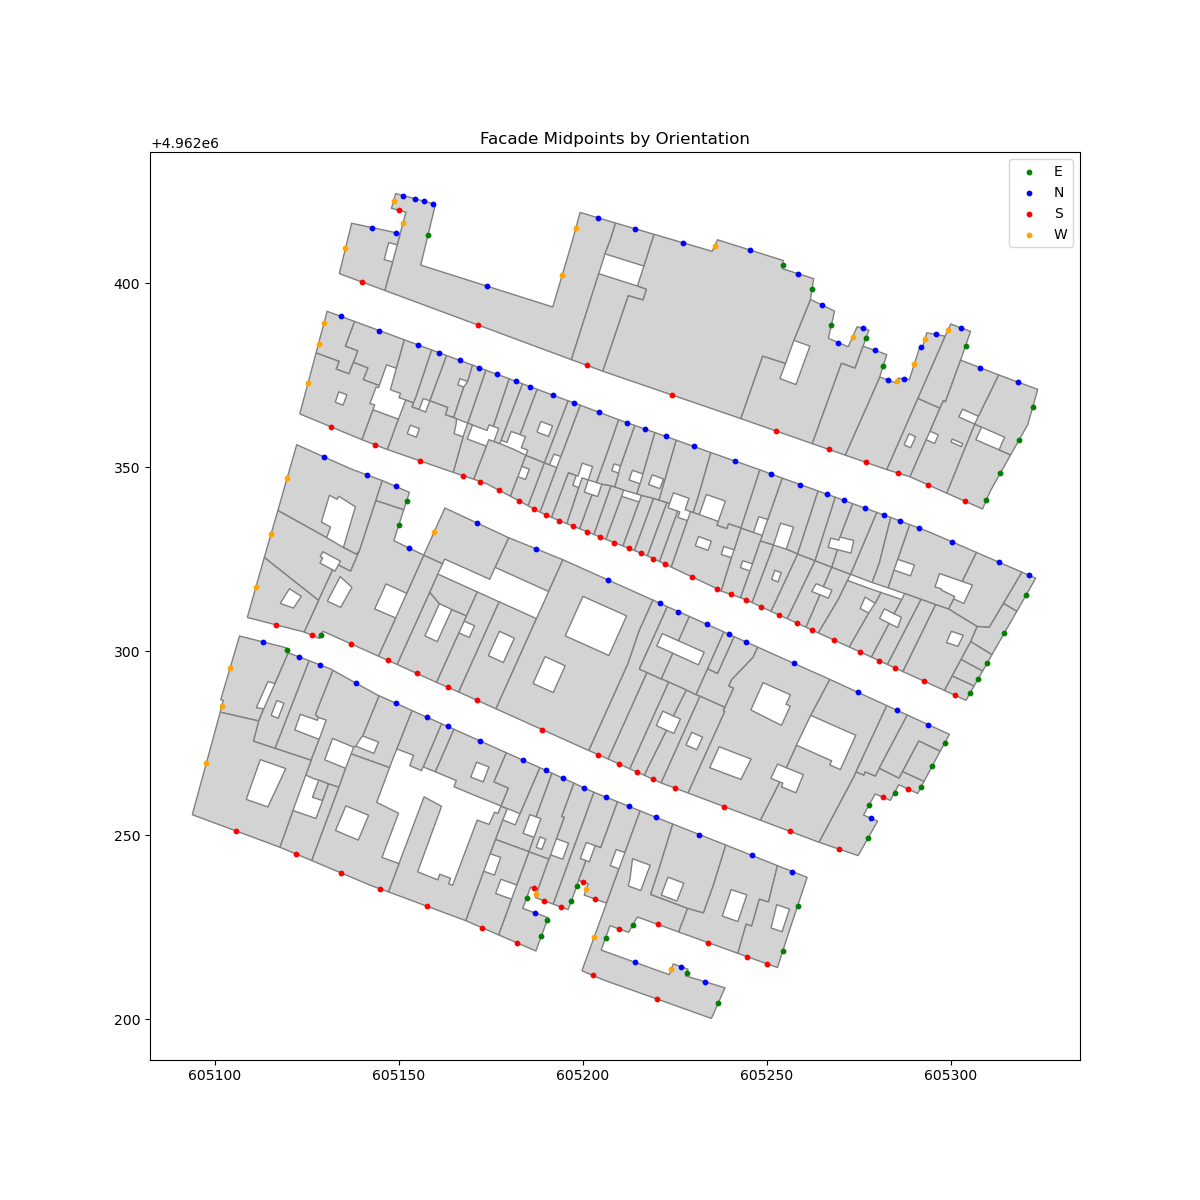

In [136]:
# Plot midpoints grouped by orientation
fig, ax = plt.subplots(figsize=(12, 12))
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot midpoints by orientation, using different colors or markers for each orientation
colors = {'N': 'blue', 'NE': 'cyan', 'E': 'green', 'SE': 'yellow', 'S': 'orange', 'SW': 'red', 'W': 'purple', 'NW': 'pink'}
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}
for orientation, group in oriented_facade_segments_gdf.groupby('orientation'):
    group.plot(ax=ax, color=colors.get(orientation, 'black'), markersize=10, label=orientation)

plt.legend()
plt.title("Facade Midpoints by Orientation")
plt.show()

In [137]:
# Process boundary segments to assign orientation based on exterior boundaries
def add_orientation_to_segments(exterior_boundaries_gdf):
    oriented_segments = []

    for index, row in exterior_boundaries_gdf.iterrows():
        boundary = row['geometry']  # Get the exterior boundary LINEARRING
        group_id = row['group_id']

        # Iterate over each segment of the exterior boundary
        exterior_coords = list(boundary.coords)
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            segment = LineString([p1, p2])

            # Calculate the azimuth and orientation for the segment
            azimuth = calculate_azimuth(p1, p2)
            orientation = classify_orientation(azimuth)

            # Add the orientation to the boundary segment data
            oriented_segments.append({
                'group_id': group_id,
                'geometry': segment,
                'orientation': orientation
            })

    # Create a new GeoDataFrame with oriented segments
    oriented_segments_gdf = gpd.GeoDataFrame(oriented_segments, geometry='geometry', crs=exterior_boundaries_gdf.crs)
    
    return oriented_segments_gdf

# Apply the function to classify and add orientation to boundary segments
oriented_segments_gdf = add_orientation_to_segments(exterior_boundaries_gdf)

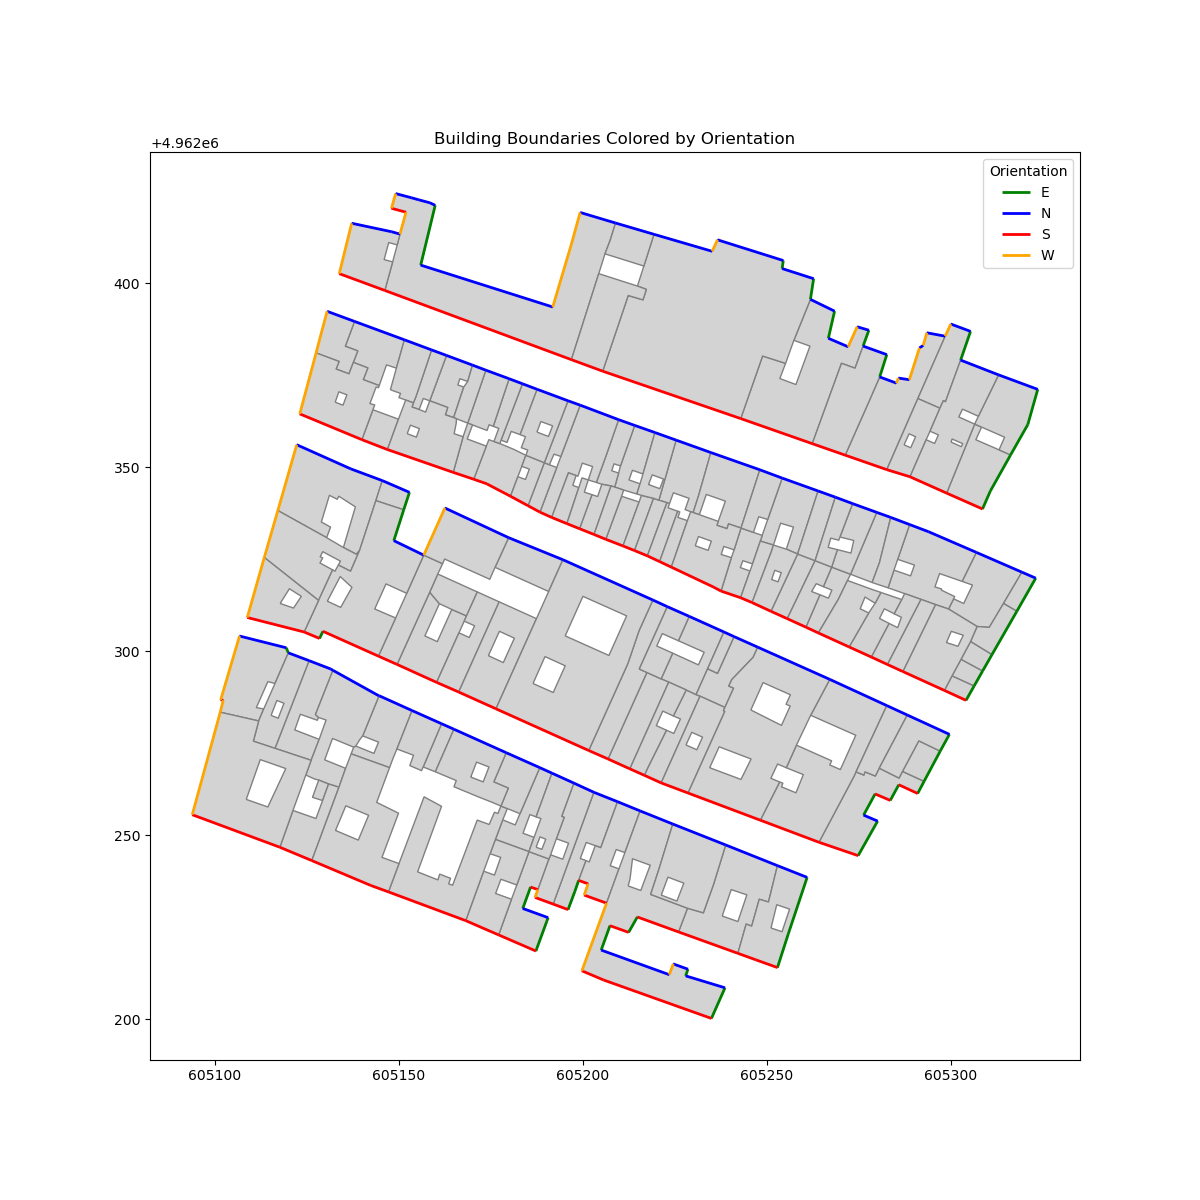

In [139]:
# Plot the segments, coloring by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings or blocks if needed (optional, for context)
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot the oriented segments, color-coded by their orientation
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}
for orientation, group in oriented_segments_gdf.groupby('orientation'):
    group.plot(ax=ax, color=colors[orientation], linewidth=2, label=orientation)

# Add legend
plt.legend(title="Orientation")
plt.title("Building Boundaries Colored by Orientation")
plt.show()

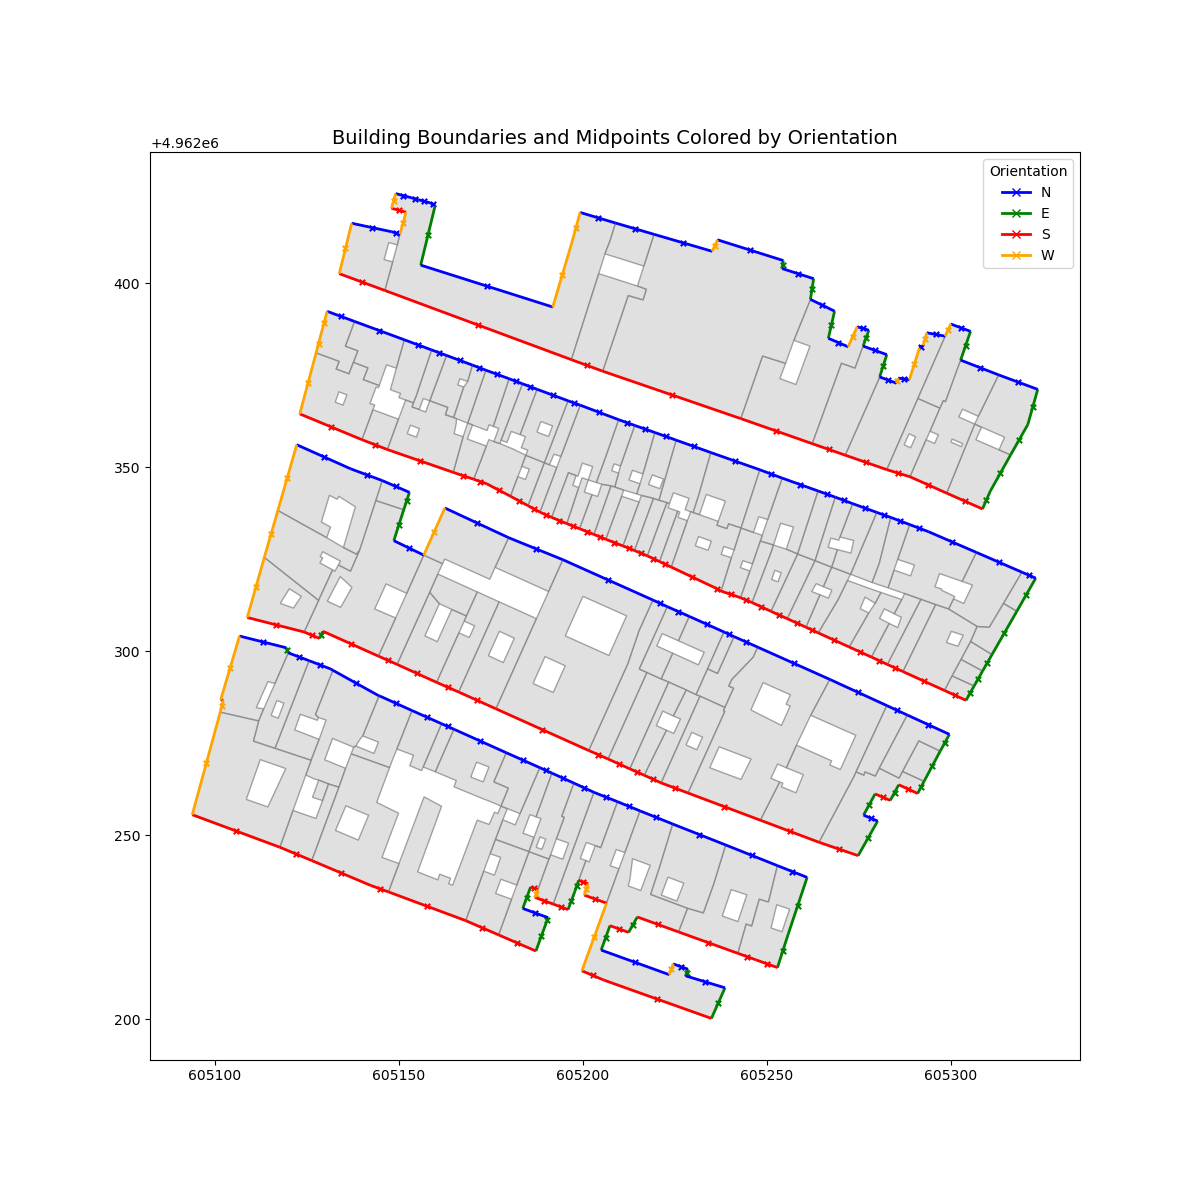

In [140]:
# Plot the segments and midpoints, coloring by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings or blocks for context
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.7)  # Slight transparency for context

# Define colors for orientations
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}

# Plot the oriented segments (building boundaries) and midpoints together
for orientation, group in oriented_segments_gdf.groupby('orientation'):
    # Plot boundary segments
    group.plot(ax=ax, color=colors[orientation], linewidth=2)
    
    # Plot midpoints with the same color but different marker
    oriented_facade_segments_gdf.groupby('orientation').get_group(orientation).plot(ax=ax, color=colors[orientation], markersize=15, marker='x')

# Add a combined legend only once for both lines and midpoints
legend_labels = [plt.Line2D([0], [0], color=colors[direction], lw=2, marker='x', label=f'{direction}')
                 for direction in colors]
ax.legend(handles=legend_labels, title="Orientation", loc='upper right')

# Improve title and axis display
plt.title("Building Boundaries and Midpoints Colored by Orientation", fontsize=14)

# Show the plot
plt.show()

In [141]:
from tqdm import tqdm
from shapely.ops import nearest_points

# Ensure that building_id in oriented_facade_segments_gdf matches the index type of gdf_projected
oriented_facade_segments_gdf['building_id'] = oriented_facade_segments_gdf['building_id'].astype(gdf_projected.index.dtype)

# Initialize an empty list to store the final results
matched_rows = []

# Iterate over each unique group_id and track progress using tqdm
for group in tqdm(oriented_facade_segments_gdf['group_id'].unique(), desc="Processing Groups"):
    # Select all midpoints and edges for the current group
    group_midpoints = oriented_facade_segments_gdf[oriented_facade_segments_gdf['group_id'] == group]
    group_edges = oriented_segments_gdf[oriented_segments_gdf['group_id'] == group]
    
    # Iterate over each midpoint in the group
    for idx, midpoint_row in group_midpoints.iterrows():
        midpoint = midpoint_row['geometry']  # Get the midpoint geometry
        
        # Find the closest edge to this midpoint
        closest_edge = None
        min_distance = float('inf')
        for _, edge_row in group_edges.iterrows():
            edge = edge_row['geometry']  # Get the edge geometry
            # Calculate the distance between the midpoint and the edge
            distance = midpoint.distance(edge)
            if distance < min_distance:
                min_distance = distance
                closest_edge = edge_row

        # Get the building details from gdf_projected using building_id
        building_id = midpoint_row['building_id']
        building_info = gdf_projected.loc[building_id]  # Now building_id should match the type of gdf_projected's index

        # Add the matched row (midpoint + closest edge + osm_id) to the result
        matched_rows.append({
            'group_id': group,
            'building_id': building_id,
            'osm_id': building_info['osm_id'],  # Get osm_id from gdf_projected
            'geometry_midpoint': midpoint,
            'orientation_midpoint': midpoint_row['orientation'],
            'geometry_outer_edge': closest_edge['geometry'],
            'orientation_outer_edge': closest_edge['orientation']
        })


Processing Groups: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


In [142]:
# Create the first GeoDataFrame with geometry_midpoint as the active geometry
gdf_midpoint  = gpd.GeoDataFrame(matched_rows, geometry='geometry_midpoint', crs=oriented_facade_segments_gdf.crs)
# Create the second GeoDataFrame with geometry_outer_edge as the active geometry
gdf_outer_edge  = gpd.GeoDataFrame(matched_rows, geometry='geometry_outer_edge', crs=oriented_facade_segments_gdf.crs)

In [143]:
gdf_midpoint

group_id  building_id     osm_id               geometry_midpoint  \
0    block_0           34  182136815  POINT (605189.957 4962337.062)   
1    block_0           34  182136815   POINT (605186.74 4962338.654)   
2    block_0           12  182136647  POINT (605182.741 4962340.811)   
3    block_0           12  182136647   POINT (605177.148 4962343.78)   
4    block_0           12  182136647  POINT (605172.146 4962346.093)   
..       ...          ...        ...                             ...   
227  block_3          128  182138164  POINT (605303.719 4962340.791)   
228  block_3          128  182138164  POINT (605293.875 4962345.163)   
229  block_3           30  182136766  POINT (605285.746 4962348.352)   
230  block_3           30  182136766  POINT (605276.937 4962351.292)   
231  block_3           30  182136766   POINT (605266.814 4962354.82)   

    orientation_midpoint                                geometry_outer_edge  \
0                      S  LINESTRING (605191.5512054511 4962336.34351437...   
1                      S  LINESTRING (605188.3636461565 4962337.78027592...   
2                      S  LINESTRING (605185.1156428983 4962339.52716788...   
3                      S  LINESTRING (605180.3671241255 4962342.09397253...   
4                      S  LINESTRING (605173.9284834105 4962345.46647953...   
..                   ...                                                ...   
227                    S  LINESTRING (605308.5914034995 4962338.63759303...   
228                    S  LINESTRING (605298.8467651804 4962342.94473017...   
229                    S  LINESTRING (605288.9022570765 4962347.38194431...   
230                    S  LINESTRING (605282.589834345 4962349.323046219...   
231                    S  LINESTRING (605271.2850887672 4962353.26022057...   

    orientation_outer_edge  
0                        S  
1                        S  
2                        S  
3                        S  
4                        S  
..                     ...  
227                      S  
228                      S  
229                      S  
230                      S  
231                      S  

[232 rows x 7 columns]

In [144]:
import cv2
import numpy as np
import math
import geopandas as gpd
import matplotlib.pyplot as plt

In [145]:
def calculate_yaw_pitch(camera_coords, target_coords):
    """
    Calculate yaw (theta) and pitch (phi) angles between the camera position and target point.

    Parameters:
    - camera_coords: (x, y, z) coordinates of the camera position.
    - target_coords: (x, y, z) coordinates of the target point.

    Returns:
    - yaw (theta) in degrees, pitch (phi) in degrees.
    """
    # Unpack the coordinates
    x1, y1, z1 = camera_coords
    x2, y2, z2 = target_coords

    # Calculate differences in x, y, z
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    # Calculate the yaw (theta): horizontal direction
    theta = math.atan2(dy, dx)  # Azimuth
    theta_deg = math.degrees(theta)
    
    # Calculate the pitch (phi): vertical direction
    horizontal_distance = math.sqrt(dx**2 + dy**2)
    phi = math.atan2(dz, horizontal_distance)  # Elevation angle
    phi_deg = math.degrees(phi)
    
    return theta_deg, phi_deg

def equirectangular_to_perspective_from_image(img, fov, theta, phi, roll, height, width):
    """
    Convert an equirectangular (360-degree) image to a perspective projection using an already loaded image.
    
    Parameters:
    - img: The equirectangular image already loaded (preprocessed if needed).
    - fov: Field of view of the output image (in degrees).
    - theta: Yaw angle (azimuth) in degrees.
    - phi: Pitch angle in degrees.
    - roll: Roll angle in degrees.
    - height: Output image height.
    - width: Output image width.

    Returns:
    - Perspective projection of the given equirectangular image.
    """
    # Convert angles to radians
    fov = math.radians(fov)
    theta = math.radians(theta)
    phi = math.radians(phi)
    roll = math.radians(roll)
    
    # Prepare perspective output image
    out_img = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Get dimensions of the equirectangular image
    h, w, _ = img.shape
    
    # Calculate the focal length based on the FOV and image width
    f = width / (2 * math.tan(fov / 2))
    
    # Create rotation matrices based on yaw, pitch, and roll
    Rx = np.array([[1, 0, 0], [0, math.cos(phi), -math.sin(phi)], [0, math.sin(phi), math.cos(phi)]])  # Pitch
    Ry = np.array([[math.cos(theta), 0, math.sin(theta)], [0, 1, 0], [-math.sin(theta), 0, math.cos(theta)]])  # Yaw
    Rz = np.array([[math.cos(roll), -math.sin(roll), 0], [math.sin(roll), math.cos(roll), 0], [0, 0, 1]])  # Roll
    
    R = Rz @ Ry @ Rx  # Combined rotation matrix
    
    # Loop over each pixel in the perspective image
    for i in range(height):
        for j in range(width):
            # Convert pixel coordinates to angles in the perspective image
            x = (j - width / 2) / f
            y = (i - height / 2) / f
            
            # Calculate direction vector for this pixel
            direction = np.array([x, y, 1])
            direction = direction / np.linalg.norm(direction)  # Normalize the vector
            
            # Apply rotation to the direction vector
            direction = R @ direction
            
            # Calculate spherical coordinates (theta, phi) for the pixel
            theta_p = math.atan2(direction[0], direction[2])
            phi_p = math.asin(direction[1])
            
            # Convert back to equirectangular coordinates
            u = (theta_p / (2 * math.pi) + 0.5) * w
            v = (phi_p / math.pi + 0.5) * h
            
            # Ensure the coordinates are within bounds and use interpolation
            u = np.clip(u, 0, w - 1)
            v = np.clip(v, 0, h - 1)
            
            # Bilinear interpolation for better quality
            u_floor = int(np.floor(u))
            v_floor = int(np.floor(v))
            u_ceil = min(u_floor + 1, w - 1)
            v_ceil = min(v_floor + 1, h - 1)
            
            # Interpolation weights
            wu = u - u_floor
            wv = v - v_floor
            
            # Interpolate between four surrounding pixels
            top_left = img[v_floor, u_floor]
            top_right = img[v_floor, u_ceil]
            bottom_left = img[v_ceil, u_floor]
            bottom_right = img[v_ceil, u_ceil]
            
            top = (1 - wu) * top_left + wu * top_right
            bottom = (1 - wu) * bottom_left + wu * bottom_right
            pixel_value = (1 - wv) * top + wv * bottom
            
            # Assign the pixel value
            out_img[i, j] = pixel_value.astype(np.uint8)
    
    return out_img

In [103]:
# Find the relevant pictures
gdf = gpd.read_file('data/DEMO_TRACCIATO/RUN.shp')

gdf_subset = gdf[gdf['FOTO'].str.contains("pano_000021")]

In [115]:
# Create an empty list to store the results
combined_rows = []

# Iterate over each point in gdf_midpoint
for i, row in gdf_midpoint.iterrows():
    # Get the geometry (point) from gdf_midpoint
    point_gdf_midpoint = row['geometry_midpoint']

    # Calculate the distance from this point to every point in gdf_subset
    distances = gdf_subset.geometry.distance(point_gdf_midpoint)

    # Find the index of the minimum distance (closest point)
    min_distance_index = distances.idxmin()
    min_distance_value = distances.min()

    # Get the closest row from gdf_subset
    closest_row = gdf_subset.loc[min_distance_index]

    # Combine the row from gdf_midpoint and the closest row from gdf_subset
    combined_row = pd.concat([row, closest_row], axis=0)

    # Append the combined row to the results list
    combined_rows.append(combined_row)

# Convert the list of combined rows into a new GeoDataFrame
gdf_combined = pd.DataFrame(combined_rows)

# Convert to GeoDataFrame if needed
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry='geometry_midpoint', crs=gdf_midpoint.crs)

       group_id  building_id      osm_id               geometry_midpoint  \
0  standalone_0            0  1264869089  POINT (602921.803 4962062.734)   
1  standalone_0            0  1264869089  POINT (602912.651 4962058.731)   
2  standalone_0            0  1264869089   POINT (602907.75 4962067.414)   
3  standalone_0            0  1264869089  POINT (602916.902 4962071.416)   
4  standalone_1            1  1264869092   POINT (602918.12 4962046.497)   

  orientation_midpoint                                geometry_outer_edge  \
0                    E  LINESTRING (602923.9280891734 4962069.07870088...   
1                    S  LINESTRING (602919.6777434858 4962056.38830721...   
2                    W  LINESTRING (602905.6251786421 4962061.07451367...   
3                    N  LINESTRING (602909.8757260251 4962073.75378936...   
4                    E  LINESTRING (602919.8164118801 4962051.67936921...   

  orientation_outer_edge           X            Y       Z  ... FRAME COMUNE  \
0

In [116]:
gdf_combined

group_id  building_id      osm_id               geometry_midpoint  \
0   standalone_0            0  1264869089  POINT (602921.803 4962062.734)   
1   standalone_0            0  1264869089  POINT (602912.651 4962058.731)   
2   standalone_0            0  1264869089   POINT (602907.75 4962067.414)   
3   standalone_0            0  1264869089  POINT (602916.902 4962071.416)   
4   standalone_1            1  1264869092   POINT (602918.12 4962046.497)   
5   standalone_1            1  1264869092  POINT (602909.008 4962043.728)   
6   standalone_1            1  1264869092   POINT (602903.294 4962051.32)   
7   standalone_1            1  1264869092  POINT (602912.405 4962054.089)   
8   standalone_2            2  1264869093   POINT (602902.68 4962040.238)   
9   standalone_2            2  1264869093  POINT (602897.452 4962036.216)   
10  standalone_2            2  1264869093   POINT (602903.204 4962028.73)   
11  standalone_2            2  1264869093  POINT (602911.814 4962030.234)   
12  standalone_2            2  1264869093  POINT (602913.388 4962035.187)   
13  standalone_2            2  1264869093  POINT (602911.611 4962036.976)   
14  standalone_2            2  1264869093  POINT (602907.807 4962038.176)   
15  standalone_3            3  1264869094  POINT (602902.598 4962022.098)   
16  standalone_3            3  1264869094  POINT (602906.315 4962017.213)   
17  standalone_3            3  1264869094  POINT (602904.412 4962011.316)   
18  standalone_3            3  1264869094  POINT (602896.405 4962010.226)   
19  standalone_3            3  1264869094  POINT (602891.099 4962017.508)   
20  standalone_3            3  1264869094    POINT (602894.87 4962021.88)   
21  standalone_3            3  1264869094  POINT (602897.404 4962022.415)   
22  standalone_4            4  1264869095  POINT (602895.498 4962003.879)   
23  standalone_4            4  1264869095  POINT (602885.315 4962001.277)   
24  standalone_4            4  1264869095  POINT (602892.209 4961993.365)   
25  standalone_4            4  1264869095  POINT (602902.392 4961995.967)   
26  standalone_5           10  1264869111  POINT (602890.475 4962080.232)   
27  standalone_5           10  1264869111   POINT (602896.47 4962072.139)   
28  standalone_5           10  1264869111   POINT (602886.806 4962069.24)   
29  standalone_5           10  1264869111  POINT (602880.811 4962077.333)   
30  standalone_6           12  1264869113  POINT (602875.326 4962061.212)   
31  standalone_6           12  1264869113  POINT (602881.442 4962053.276)   
32  standalone_6           12  1264869113  POINT (602891.104 4962055.998)   
33  standalone_6           12  1264869113  POINT (602884.989 4962063.933)   
34  standalone_7           13  1264869114  POINT (602881.525 4962047.328)   
35  standalone_7           13  1264869114   POINT (602873.51 4962043.505)   
36  standalone_7           13  1264869114  POINT (602877.063 4962035.973)   
37  standalone_7           13  1264869114  POINT (602883.451 4962037.219)   
38  standalone_7           13  1264869114  POINT (602885.131 4962039.969)   
39  standalone_7           13  1264869114  POINT (602886.759 4962042.545)   
40  standalone_8           14  1264869115  POINT (602874.458 4962030.975)   
41  standalone_8           14  1264869115  POINT (602879.481 4962023.017)   
42  standalone_8           14  1264869115   POINT (602870.75 4962019.466)   
43  standalone_8           14  1264869115  POINT (602865.726 4962027.425)   
44  standalone_9           15  1264869116  POINT (602869.022 4962014.016)   
45  standalone_9           15  1264869116  POINT (602875.055 4962005.529)   
46  standalone_9           15  1264869116  POINT (602865.177 4962002.154)   
47  standalone_9           15  1264869116  POINT (602859.144 4962010.641)   

   orientation_midpoint                                geometry_outer_edge  \
0                     E  LINESTRING (602923.9280891734 4962069.07870088...   
1                     S  LINESTRING (602919.6777434858 4962056.38830721...   


In [109]:
# Iterate over each point in gdf1
for i, row in gdf_midpoint.iterrows():
    # Get the geometry (point) from gdf1
    point_gdf_subset = row['geometry_midpoint']

    # Calculate the distance from this point to every point in gdf2
    distances = gdf_subset.geometry.distance(point_gdf_subset)

    # Find the index of the minimum distance (closest point)
    min_distance_index = distances.idxmin()
    min_distance_value = distances.min()

# Add the matched row (midpoint + closest edge + osm_id) to the result
matched_rows.append({
    'group_id': group,
    'building_id': building_id,
    'osm_id': building_info['osm_id'],  # Get osm_id from gdf_projected
    'geometry_midpoint': midpoint,
    'orientation_midpoint': midpoint_row['orientation'],
    'geometry_outer_edge': closest_edge['geometry'],
    'orientation_outer_edge': closest_edge['orientation']
})

# Store the closest point's index and the distance in gdf1
gdf1.at[i, 'closest_index'] = min_distance_index
gdf1.at[i, 'closest_distance'] = min_distance_value

# Now, gdf1 has the index of the closest point from gdf2 and the corresponding distance
print(gdf1[['closest_index', 'closest_distance']])


NameError: name 'gdf1' is not defined

In [105]:
gdf_subset

X            Y       Z RUN                    FOTO PATH  FRAME  \
480  602904.014  4962083.443  95.311  21  pano_000021_000000.jpg   21      0   
481  602904.792  4962081.568  95.327  21  pano_000021_000001.jpg   21      1   
482  602904.434  4962078.988  95.306  21  pano_000021_000002.jpg   21      2   
483  602903.280  4962076.272  95.331  21  pano_000021_000003.jpg   21      3   
484  602902.028  4962073.501  95.357  21  pano_000021_000004.jpg   21      4   
485  602900.798  4962070.659  95.377  21  pano_000021_000005.jpg   21      5   
486  602899.650  4962067.812  95.396  21  pano_000021_000006.jpg   21      6   
487  602898.578  4962064.912  95.417  21  pano_000021_000007.jpg   21      7   
488  602897.607  4962062.010  95.437  21  pano_000021_000008.jpg   21      8   
489  602896.698  4962059.057  95.461  21  pano_000021_000009.jpg   21      9   
490  602895.851  4962056.064  95.498  21  pano_000021_000010.jpg   21     10   
491  602895.018  4962053.152  95.520  21  pano_000021_000011.jpg   21     11   
492  602894.088  4962050.244  95.534  21  pano_000021_000012.jpg   21     12   
493  602893.094  4962047.347  95.540  21  pano_000021_000013.jpg   21     13   
494  602892.094  4962044.457  95.547  21  pano_000021_000014.jpg   21     14   
495  602891.120  4962041.491  95.554  21  pano_000021_000015.jpg   21     15   
496  602890.180  4962038.591  95.566  21  pano_000021_000016.jpg   21     16   
497  602889.256  4962035.653  95.591  21  pano_000021_000017.jpg   21     17   
498  602888.370  4962032.761  95.602  21  pano_000021_000018.jpg   21     18   
499  602887.481  4962029.857  95.620  21  pano_000021_000019.jpg   21     19   
500  602886.592  4962026.960  95.630  21  pano_000021_000020.jpg   21     20   
501  602885.655  4962024.093  95.637  21  pano_000021_000021.jpg   21     21   
502  602884.654  4962021.137  95.644  21  pano_000021_000022.jpg   21     22   
503  602883.658  4962018.230  95.639  21  pano_000021_000023.jpg   21     23   
504  602882.645  4962015.295  95.627  21  pano_000021_000024.jpg   21     24   
505  602881.624  4962012.391  95.614  21  pano_000021_000025.jpg   21     25   
506  602880.695  4962009.522  95.602  21  pano_000021_000026.jpg   21     26   
507  602879.801  4962006.597  95.619  21  pano_000021_000027.jpg   21     27   
508  602878.962  4962003.621  95.617  21  pano_000021_000028.jpg   21     28   
509  602878.311  4962000.599  95.616  21  pano_000021_000029.jpg   21     29   
510  602877.851  4961997.595  95.604  21  pano_000021_000030.jpg   21     30   
511  602877.085  4961994.917  95.608  21  pano_000021_000031.jpg   21     31   

    COMUNE   Heading FRAME_PAD  ANNO     Roll    Pitch       DATA STRUMENTO  \
480  PARMA -42.71712      0000  2023  0.82620 -0.67155 2023-12-06      MX50   
481  PARMA -12.27922      0001  2023  1.13108 -0.75424 2023-12-06      MX50   
482  PARMA  15.55530      0002  2023  0.23680 -1.77759 2023-12-06      MX50   
483  PARMA  22.94099      0003  2023 -0.89302 -1.48110 2023-12-06      MX50   
484  PARMA  22.53492      0004  2023 -1.20375 -1.18955 2023-12-06      MX50   
485  PARMA  21.56031      0005  2023 -1.43915 -1.02997 2023-12-06      MX50   
486  PARMA  20.01280      0006  2023 -1.35819 -1.03970 2023-12-06      MX50   
487  PARMA  18.16503      0007  2023 -1.41043 -0.98608 2023-12-06      MX50   
488  PARMA  16.53554      0008  2023 -1.53197 -1.05342 2023-12-06      MX50   
489  PARMA  15.39614      0009  2023 -1.59867 -1.17314 2023-12-06      MX50   
490  PARMA  14.80000      0010  2023 -1.05472 -0.85174 2023-12-06      MX50   
491  PARMA  15.61993      0011  2023 -0.64888 -0.79666 2023-12-06      MX50   
492  PARMA  17.12325      0012  2023 -0.85246 -0.71583 2023-12-06      MX50   
493  PARMA  17.74023      0013  2023 -1.14810 -0.74133 2023-12-06      MX50   
494  PARMA  17.43287      0014  2023 -1.49854 -0.79602 2023-12-06      MX50   
495  PARMA  16.80276      0015  2023 -1.37871 -0.20448 2023-12-06      MX50   
496  PARMA  16.35113      0016

In [104]:
gdf_midpoint

group_id  building_id      osm_id               geometry_midpoint  \
0   standalone_0            0  1264869089  POINT (602921.803 4962062.734)   
1   standalone_0            0  1264869089  POINT (602912.651 4962058.731)   
2   standalone_0            0  1264869089   POINT (602907.75 4962067.414)   
3   standalone_0            0  1264869089  POINT (602916.902 4962071.416)   
4   standalone_1            1  1264869092   POINT (602918.12 4962046.497)   
5   standalone_1            1  1264869092  POINT (602909.008 4962043.728)   
6   standalone_1            1  1264869092   POINT (602903.294 4962051.32)   
7   standalone_1            1  1264869092  POINT (602912.405 4962054.089)   
8   standalone_2            2  1264869093   POINT (602902.68 4962040.238)   
9   standalone_2            2  1264869093  POINT (602897.452 4962036.216)   
10  standalone_2            2  1264869093   POINT (602903.204 4962028.73)   
11  standalone_2            2  1264869093  POINT (602911.814 4962030.234)   
12  standalone_2            2  1264869093  POINT (602913.388 4962035.187)   
13  standalone_2            2  1264869093  POINT (602911.611 4962036.976)   
14  standalone_2            2  1264869093  POINT (602907.807 4962038.176)   
15  standalone_3            3  1264869094  POINT (602902.598 4962022.098)   
16  standalone_3            3  1264869094  POINT (602906.315 4962017.213)   
17  standalone_3            3  1264869094  POINT (602904.412 4962011.316)   
18  standalone_3            3  1264869094  POINT (602896.405 4962010.226)   
19  standalone_3            3  1264869094  POINT (602891.099 4962017.508)   
20  standalone_3            3  1264869094    POINT (602894.87 4962021.88)   
21  standalone_3            3  1264869094  POINT (602897.404 4962022.415)   
22  standalone_4            4  1264869095  POINT (602895.498 4962003.879)   
23  standalone_4            4  1264869095  POINT (602885.315 4962001.277)   
24  standalone_4            4  1264869095  POINT (602892.209 4961993.365)   
25  standalone_4            4  1264869095  POINT (602902.392 4961995.967)   
26  standalone_5           10  1264869111  POINT (602890.475 4962080.232)   
27  standalone_5           10  1264869111   POINT (602896.47 4962072.139)   
28  standalone_5           10  1264869111   POINT (602886.806 4962069.24)   
29  standalone_5           10  1264869111  POINT (602880.811 4962077.333)   
30  standalone_6           12  1264869113  POINT (602875.326 4962061.212)   
31  standalone_6           12  1264869113  POINT (602881.442 4962053.276)   
32  standalone_6           12  1264869113  POINT (602891.104 4962055.998)   
33  standalone_6           12  1264869113  POINT (602884.989 4962063.933)   
34  standalone_7           13  1264869114  POINT (602881.525 4962047.328)   
35  standalone_7           13  1264869114   POINT (602873.51 4962043.505)   
36  standalone_7           13  1264869114  POINT (602877.063 4962035.973)   
37  standalone_7           13  1264869114  POINT (602883.451 4962037.219)   
38  standalone_7           13  1264869114  POINT (602885.131 4962039.969)   
39  standalone_7           13  1264869114  POINT (602886.759 4962042.545)   
40  standalone_8           14  1264869115  POINT (602874.458 4962030.975)   
41  standalone_8           14  1264869115  POINT (602879.481 4962023.017)   
42  standalone_8           14  1264869115   POINT (602870.75 4962019.466)   
43  standalone_8           14  1264869115  POINT (602865.726 4962027.425)   
44  standalone_9           15  1264869116  POINT (602869.022 4962014.016)   
45  standalone_9           15  1264869116  POINT (602875.055 4962005.529)   
46  standalone_9           15  1264869116  POINT (602865.177 4962002.154)   
47  standalone_9           15  1264869116  POINT (602859.144 4962010.641)   

   orientation_midpoint                                geometry_outer_edge  \
0                     E  LINESTRING (602923.9280891734 4962069.07870088...   
1                     S  LINESTRING (602919.6777434858 4962056.38830721...   
